## Churn prediction in the Energy Sector - Netherlands

In this project we aim to understand the many factors that influence movement of customers from one energy provider to another and in result build a predictive model. The goal is to understand customer churn and predict which customers are most likely to leave and why, ideally, this model would function as a stepping stone into better customer retention.

### For each customer we have the following information:
- ``Customer_ID``: A unique customer identification number.
- ``Gender``: A dummy variable indicating if the customer who signed the contract is male (0) or
female (1).
- ``Age``: The age of the customer in years.
- ``Income``: The monthly income of the customer’s household in euros.
- ``Relation_length``: The amount of months the customer has been with the firm.
- ``Contract_length``: The amount of months the customer still has a contract with the firm. Zero
means the customer has a flexible contract, i.e., (s)he can leave anytime without paying a
fine. If the contract is more than zero months, the customer can still leave, but has to pay a
fine when leaving.
- ``Start_channel``: Indicating if the contract was filled out by the customer on the firm’s website
(“Online”) or by calling up the firm (“Phone”).
- ``Email_list``: Indicating if the customer’s email address is known by the firm (1=yes, 0=no).
- ``Home_age``: The age of the home of the customer in years.
- ``Home_label``: Energy label of the home of the customer, ranging from A (good) to G (bad).
- ``Electricity_usage``: The yearly electricity usage in kWh.
- ``Gas_usage``: The yearly gas usage in cubic meters.
- ``Province``: The province where the customer is living.
- ``Churn``: A dummy variable indicating if the customer has churned (1) or not (0).

# 1. Load Libraries

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import shapiro 
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm

In [3]:
os.getcwd()

'/Users/alejandrovillanuevalledo/Documents/GitHub/Churn-prediction/Notebook'

# 2. Load and visualize data

In [4]:
energy_supplier = pd.read_csv('/Users/alejandrovillanuevalledo/Documents/GitHub/Churn-prediction/Dataset/churn_prediction.csv')

In [5]:
energy_supplier.head()

Customer_ID  Gender  Age  Income  Relation_length  Contract_length  \
0            1       0   37    2371               50                0   
1            2       1   49    4534               22                0   
2            3       1   53    5279               67                7   
3            4       1   40    4404               40                0   
4            5       1   70    2144               74               31   

  Start_channel  Email_list  Home_age Home_label  Electricity_usage  \
0        Online           1        17          F               2238   
1        Online           0        11          E               3306   
2        Online           1        31          E               2664   
3        Online           1        12          D               2870   
4        Online           1        28          F               2983   

   Gas_usage       Province  Churn  
0       1425  Noord-Brabant      1  
1       1651  Noord-Holland      1  
2       1176     Gelderland      0  
3       1899   Zuid-Holland      1  
4       1120  Noord-Brabant      1

No null values
Number of duplicates: 0


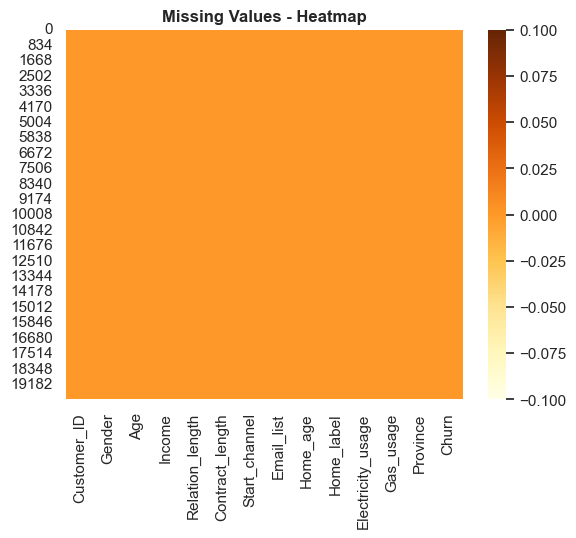

In [6]:
#missing values heatmap
nulls = energy_supplier.isnull().sum()
sns.set(rc={'figure.facecolor':'none'}) #set background to be transparent
sns.heatmap(energy_supplier.isnull(), cmap='YlOrBr')
plt.title('Missing Values - Heatmap', fontweight='bold')

#we print the missing values per column if there are missing values, or no null values otherwise
if nulls.any() > 0 :
    print(nulls)
else:
    print('No null values')

#We check for duplicated rows 
print('Number of duplicates:',energy_supplier.duplicated().sum())


The dataset has no missing values or duplicates

In [7]:
energy_supplier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Customer_ID        20000 non-null  int64 
 1   Gender             20000 non-null  int64 
 2   Age                20000 non-null  int64 
 3   Income             20000 non-null  int64 
 4   Relation_length    20000 non-null  int64 
 5   Contract_length    20000 non-null  int64 
 6   Start_channel      20000 non-null  object
 7   Email_list         20000 non-null  int64 
 8   Home_age           20000 non-null  int64 
 9   Home_label         20000 non-null  object
 10  Electricity_usage  20000 non-null  int64 
 11  Gas_usage          20000 non-null  int64 
 12  Province           20000 non-null  object
 13  Churn              20000 non-null  int64 
dtypes: int64(11), object(3)
memory usage: 2.1+ MB


In [8]:
#print number of unique values and the variable type per column 
for column in energy_supplier:
    print(column,':')
    print(energy_supplier[column].nunique(),',', energy_supplier[column].dtype)

Customer_ID :
20000 , int64
Gender :
2 , int64
Age :
88 , int64
Income :
8098 , int64
Relation_length :
226 , int64
Contract_length :
37 , int64
Start_channel :
2 , object
Email_list :
2 , int64
Home_age :
201 , int64
Home_label :
7 , object
Electricity_usage :
2840 , int64
Gas_usage :
2565 , int64
Province :
12 , object
Churn :
2 , int64


# 3. Data Cleaning and Preprocessing

## 3.1 Column formatting and Data transformation

In [9]:
#lowercase the column names
energy_supplier.columns = energy_supplier.columns.str.lower()

In [109]:
#turn categorical variables categorical 
energy_supplier['gender']= energy_supplier['gender'].astype('category')
energy_supplier['start_channel']= energy_supplier['start_channel'].astype('category')
energy_supplier['email_list']= energy_supplier['email_list'].astype('category')
energy_supplier['home_label']= energy_supplier['home_label'].astype('category')
energy_supplier['province']= energy_supplier['province'].astype('category')

Income is given in monthly €, when modelling the effect of 1€ increase in income might be hard to interpret or be insignificant, however, percentual changes in income could make more sense on churn effect. We create a new variable 'log_income' to determine whether single euro units or percentage changes are more significant in predicting customer churn.

In [11]:
#we create log of income
energy_supplier['log_income'] = np.log(energy_supplier['income'])

## 3.2 Dealing with Outliers

Dataframe subset creation with metric variables, we log transformed them to equalize variances, useful when comparing variables with different scales

In [12]:
num_variables_df = np.log(energy_supplier.select_dtypes(include=['int64', 'float64']).drop(columns= ['customer_id','churn']))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


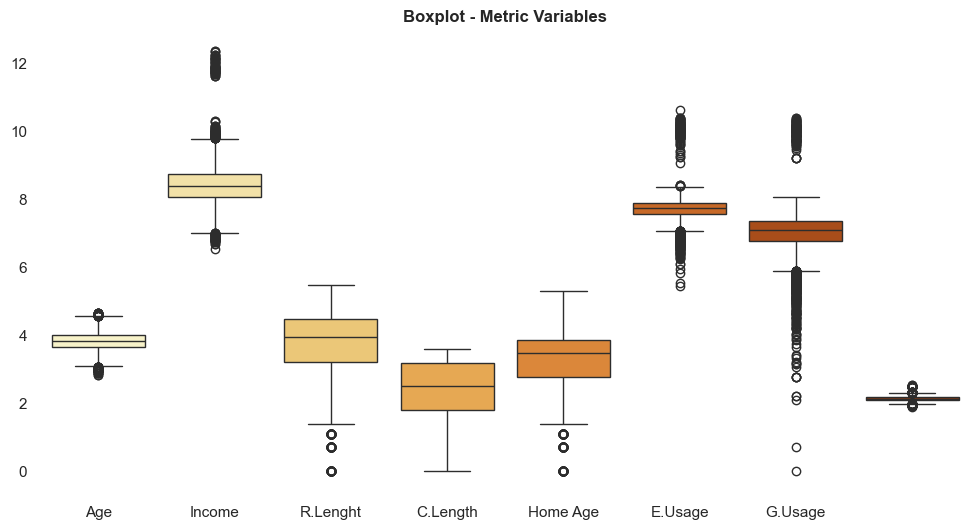

In [13]:
#Boxplots to detect outliers
plt.figure(figsize= (12,6))
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
sns.boxplot(num_variables_df, palette='YlOrBr')
plt.title('Boxplot - Metric Variables', fontweight = 'bold')
plt.xticks(np.arange(0,7), ['Age','Income','R.Lenght','C.Length', 'Home Age', 'E.Usage','G.Usage'])
plt.gca().set_facecolor('none')#set boxplot background to be transparent

Income, electricity usage and gas usage have the larger number of outliers, aditionally, we can also see sudden jump in all three variables in the upper quartile. Let's study this in more depth. 

### 3.2.1 Income Outliers

Axes(0.125,0.11;0.775x0.77)


/var/folders/y5/yrmbbwsx3sg3l8fv0bd8kxm80000gn/T/ipykernel_16834/774015112.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  print(sns.boxplot(energy_supplier['income'], palette='YlOrBr'))


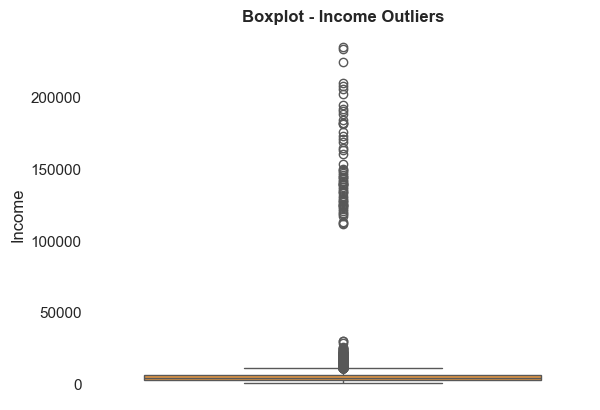

In [14]:
print(sns.boxplot(energy_supplier['income'], palette='YlOrBr'))
plt.ylabel('Income')
plt.title('Boxplot - Income Outliers', fontweight = 'bold')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent



In [15]:
#This function detects outliers in a given column and returns a list of outliers
def upper_outliers (column_data):
    Q1 = np.percentile(column_data, 25)
    Q3 = np.percentile(column_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    upper_outliers = [x for x in column_data if x > upper_bound]
    
    return sorted(upper_outliers)

outliers_income = upper_outliers(energy_supplier['income'])

In [16]:
for x in outliers_income:
    if  30000 < x < 150000:
        print(x)

30042
112130
112580
113020
117240
118980
119850
121160
122420
123600
124510
124810
124970
125680
127110
128160
128710
130080
131260
133500
134400
134900
136500
137550
139380
139480
139960
139990
141260
142250
143020
144410
144810
146170
147720
149120
149700


A steep increase can be seen in income above 30042€, the income variable is indicative of a customers monthly income. It is believed that the odd numbers come from customers inputting their yearly income instead. To fix it outliers above 50000€ will be divided by 12 to achieve monthly income.

In [17]:
#Lambda function to substitute outliers in income
energy_supplier['income'] = energy_supplier['income'].apply(lambda x: x / 12 if x > 50000 else x)

In [18]:
'''
energy_supplier['income'] = np.where(energy_supplier['income'] > 50000,
                                     energy_supplier['income'] / 12,
                                     energy_supplier['income']
'''

"\nenergy_supplier['income'] = np.where(energy_supplier['income'] > 50000,\n                                     energy_supplier['income'] / 12,\n                                     energy_supplier['income']\n"

### 3.2.2 Electricity and Gas Outliers

/var/folders/y5/yrmbbwsx3sg3l8fv0bd8kxm80000gn/T/ipykernel_16834/2531955968.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(energy_supplier['electricity_usage'], palette='YlOrBr')


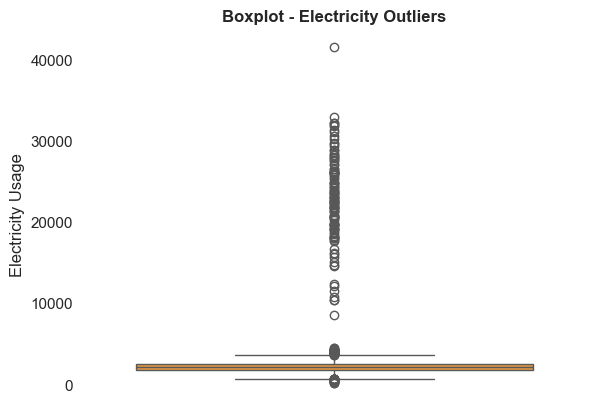

In [19]:
sns.boxplot(energy_supplier['electricity_usage'], palette='YlOrBr')
plt.ylabel('Electricity Usage')
plt.title('Boxplot - Electricity Outliers', fontweight = 'bold')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent


/var/folders/y5/yrmbbwsx3sg3l8fv0bd8kxm80000gn/T/ipykernel_16834/2985231054.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  print(sns.boxplot(energy_supplier['gas_usage'], palette='YlOrBr'))


Axes(0.125,0.11;0.775x0.77)


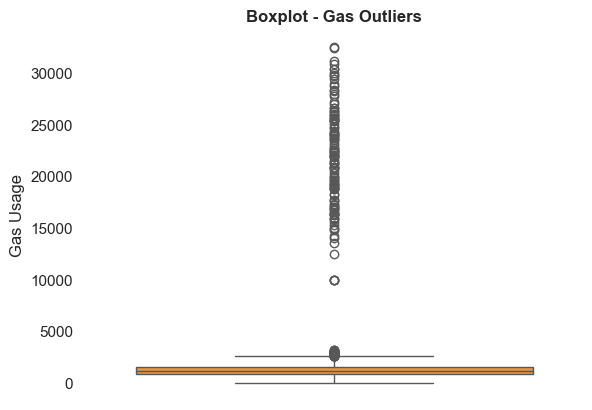

In [20]:
print(sns.boxplot(energy_supplier['gas_usage'], palette='YlOrBr'))
plt.ylabel('Gas Usage')
plt.title('Boxplot - Gas Outliers', fontweight = 'bold')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent

In [21]:
#The jump is found at 8610 KWh per year and 3209 cubic meters per year
outliers_eusage = upper_outliers(energy_supplier['electricity_usage'])
outliers_gas = upper_outliers(energy_supplier['gas_usage'])

For both electricity usage and gas usage the outlier can be due to a misreading of the consumption meters, mistakinly adding an extra 0 at the end of the level of consumption. Outliers in both variables will be divided by 10. 

In [22]:
energy_supplier['electricity_usage'] = energy_supplier['electricity_usage'].apply(lambda x: x / 10 if x > 8610 else x)
energy_supplier['gas_usage'] = energy_supplier['gas_usage'].apply(lambda x: x / 10 if x > 5000 else x)

# 4. Exploratory Data Analysis

<span style="color:red">Should I level encode some of the categorical variables (Province (Hot Encode) and Home Label to see their correlation with other variables?</span>

In [24]:
energy_supplier.drop(columns='customer_id').describe().T

count         mean          std         min          25%  \
age                20000.0    47.703600    13.285905   17.000000    38.000000   
income             20000.0  5113.190525  2876.350888  684.000000  3146.000000   
relation_length    20000.0    59.508950    42.548459    0.000000    25.000000   
contract_length    20000.0     8.951250    10.784841    0.000000     0.000000   
home_age           20000.0    38.455850    33.505020    0.000000    16.000000   
electricity_usage  20000.0  2277.619700   547.757633  231.000000  1903.000000   
gas_usage          20000.0  1210.203950   528.380912    0.000000   846.000000   
churn              20000.0     0.490100     0.499914    0.000000     0.000000   
log_income         20000.0     8.411358     0.550452    6.527958     8.053887   

                           50%          75%           max  
age                  46.000000    55.000000    104.000000  
income             4451.000000  6302.000000  30042.000000  
relation_length      51.000000    87.000000    241.000000  
contract_length       5.000000    15.000000     36.000000  
home_age             31.000000    47.000000    200.000000  
electricity_usage  2261.000000  2638.250000   8610.000000  
gas_usage          1180.000000  1553.250000   3257.000000  
churn                 0.000000     1.000000      1.000000  
log_income            8.400884     8.748622     12.368829

Here we see some interesting descriptives, i.e. the average customer is middle-aged and they have a realtively long-standing relationship with the company averaging on almost 5 years, significant compared to the 8 months of average on the contract length. 
Finally, the dataset is well balanced with the target variable 'Churn' being close to a 50-50 of customers having churned vs having remained in the company

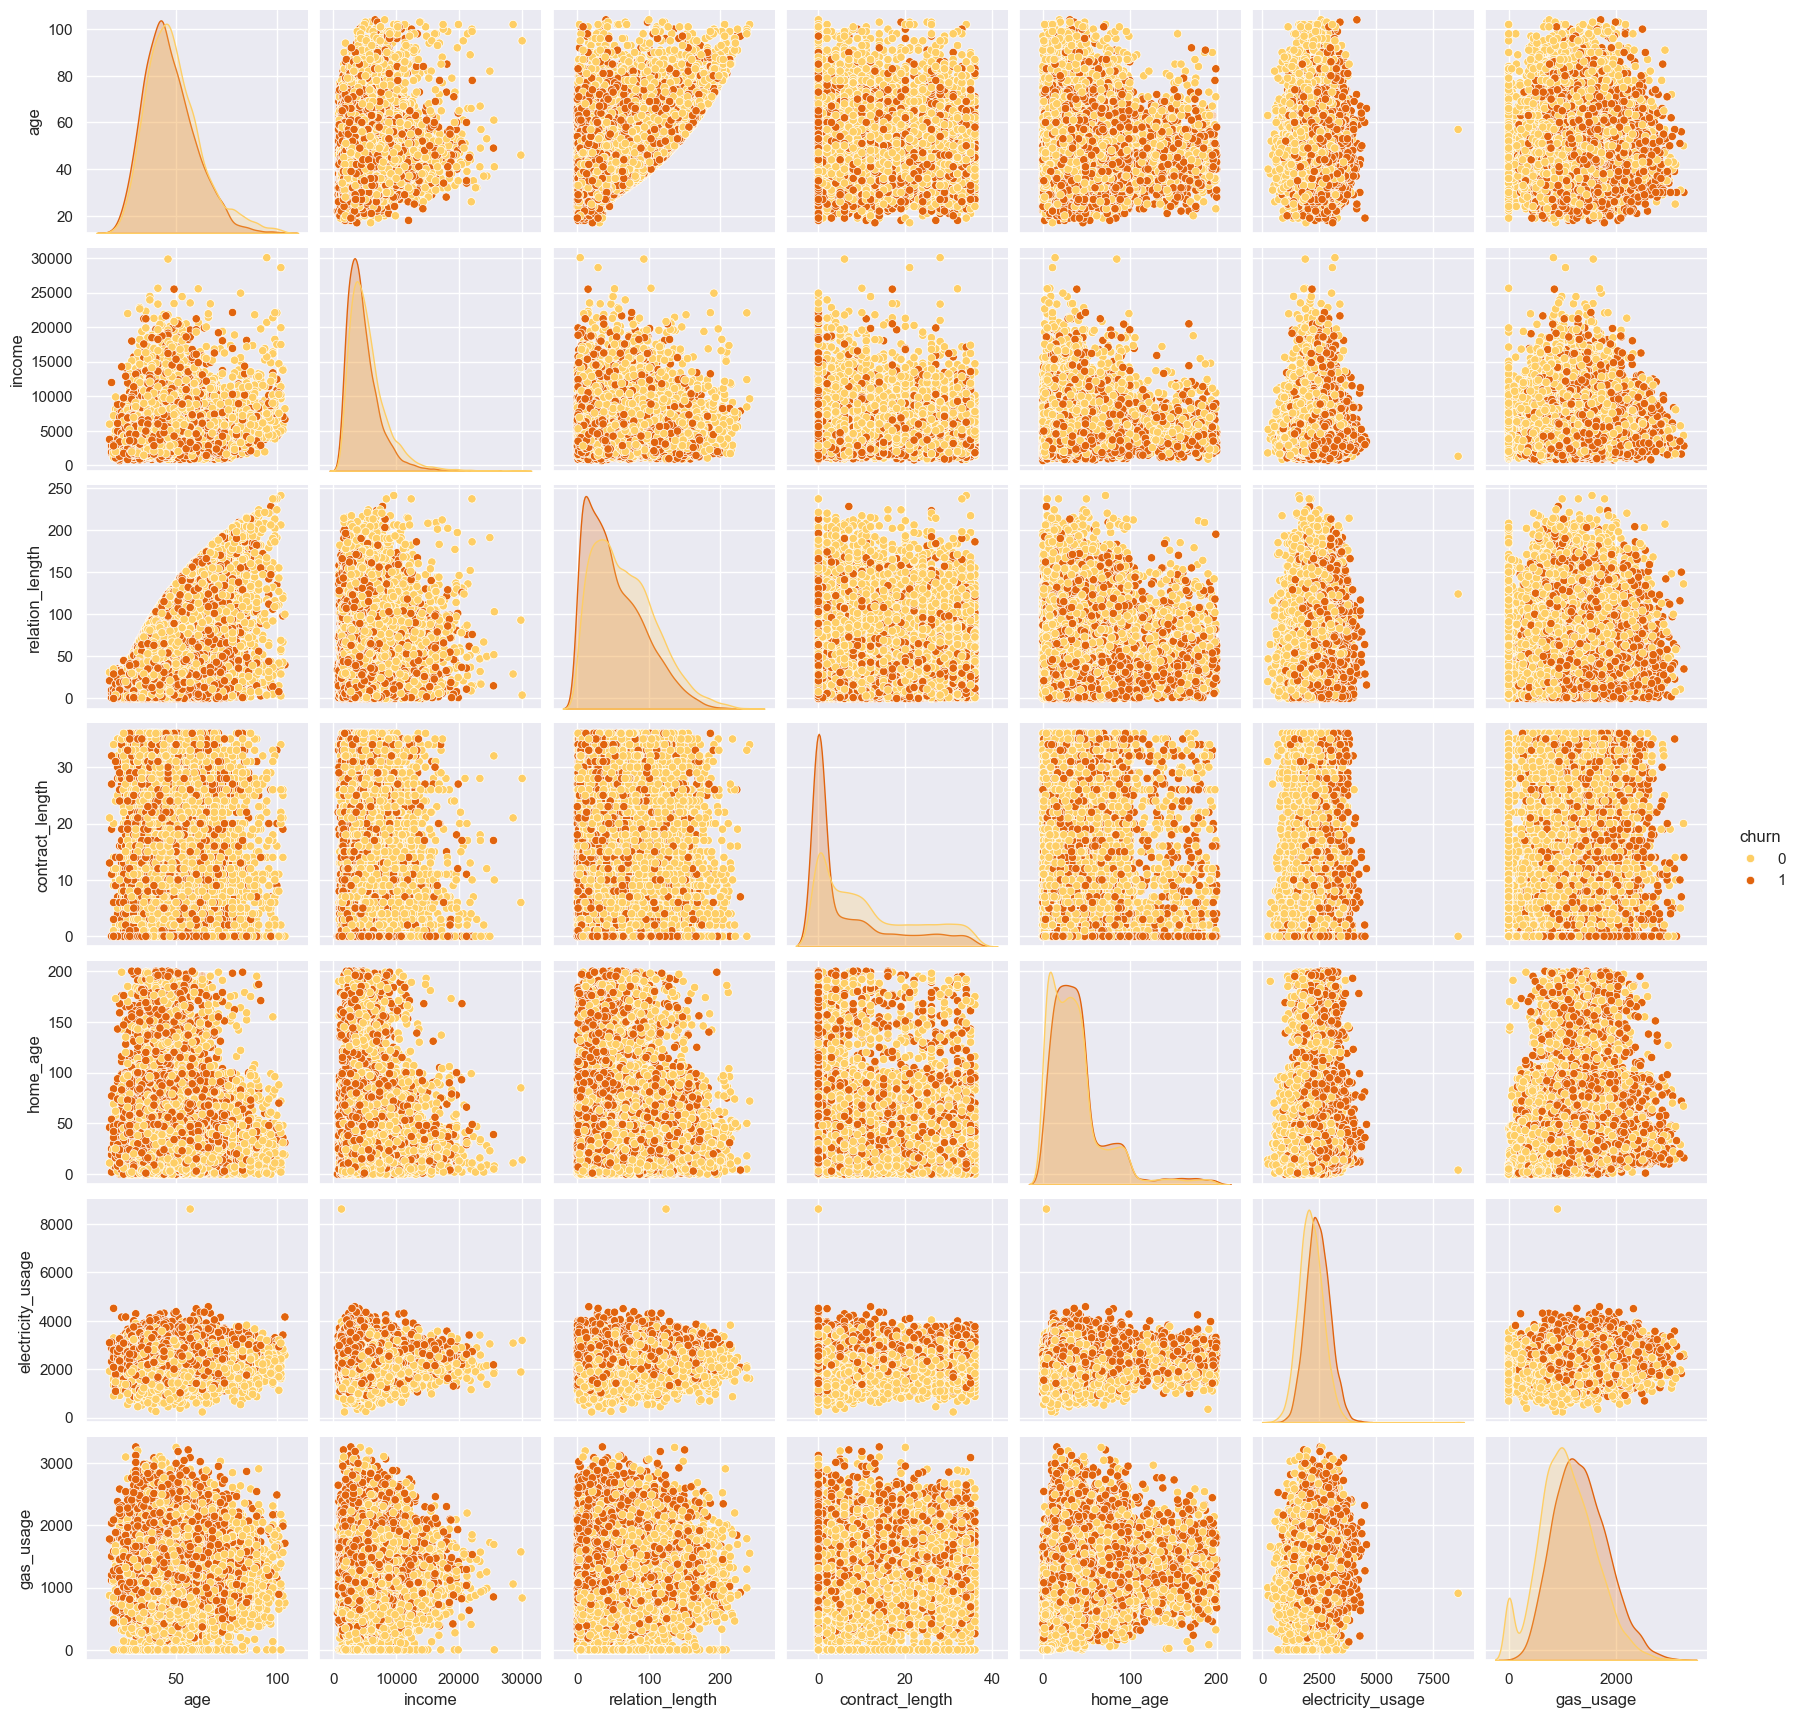

In [26]:
sns.pairplot(energy_supplier.drop(columns=['customer_id', 'log_income']), hue='churn', palette='YlOrBr')

Although quite a bit of information is presented, a few things caught my eye: 
- Age and relationship length seem to be positively correlated 
- Contract's lenght histogram has a large number of ocurrences close to 0 
- Home's age histogram has three distinct level drops 
A deeper dive will be done into these variables

/var/folders/y5/yrmbbwsx3sg3l8fv0bd8kxm80000gn/T/ipykernel_16834/1348696762.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = energy_supplier.drop(columns=['customer_id','log_income']).corr(method = 'pearson').sort_values(by = 'churn', axis = 0, ascending = False).sort_values(by = 'churn', axis = 1, ascending = False)


<Axes: >

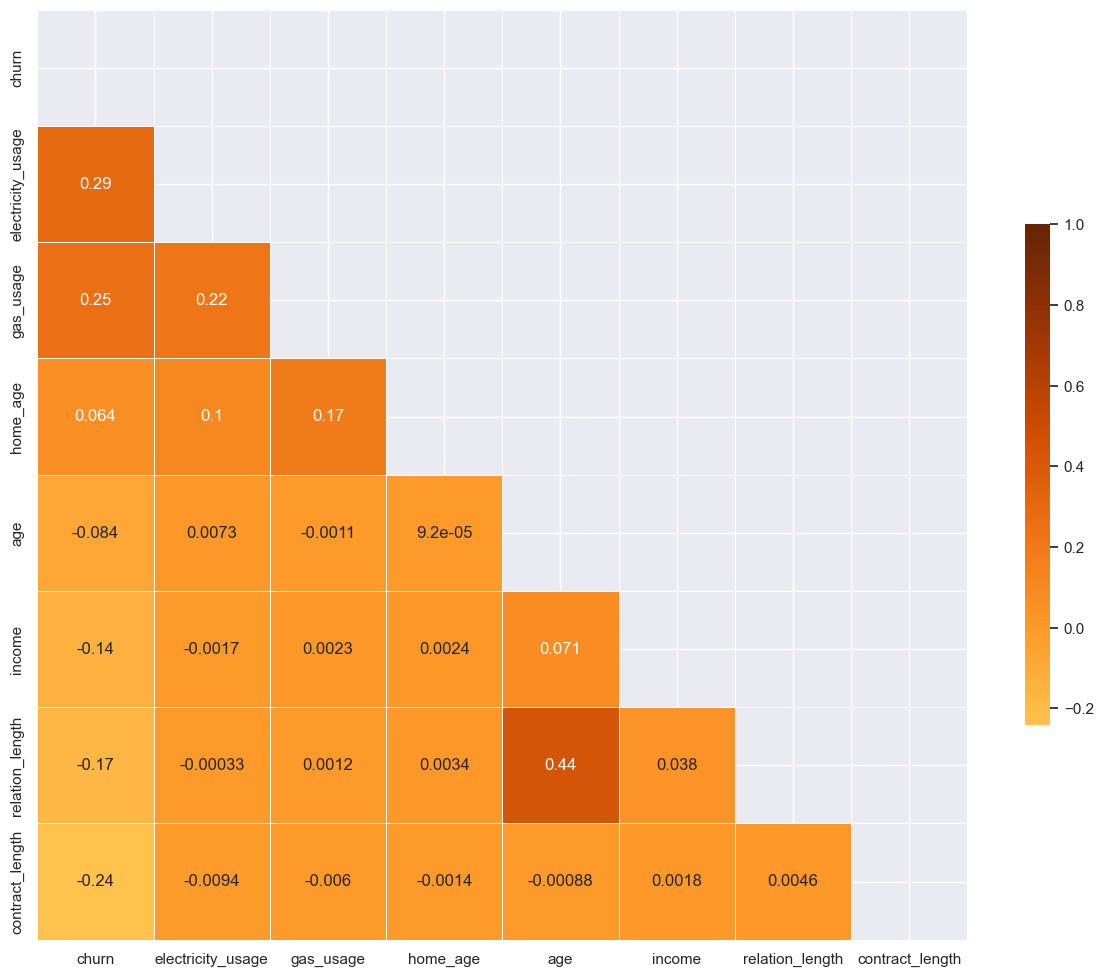

In [53]:
corr = energy_supplier.drop(columns=['customer_id','log_income']).corr(method = 'pearson').sort_values(by = 'churn', axis = 0, ascending = False).sort_values(by = 'churn', axis = 1, ascending = False)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,13))

# Generate a custom diverging colormap
cmap = sns.color_palette("YlOrBr", as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.iloc[0:8,0:8], mask=mask[0:8,0:8], cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

In this correlation heatmap: 
- Positive correlation between age and relationship length, as we had expected from the previuous graph
- Slight positive correlation between electricity and gas usage with churn 
- Slight negative correlation between income, relationship lenght and contract length with churn 
- Positive correlation between gas and electricity usage 
- Positive correlation between gas usage and home age

## 4.1 Contract Length

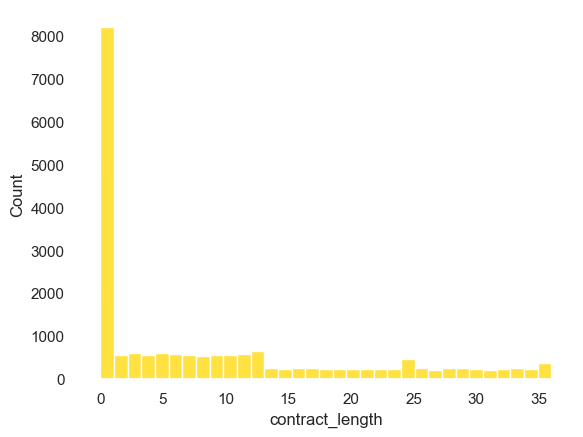

In [91]:
sns.histplot(energy_supplier['contract_length'], color='#FFD700')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent
plt.title('Contract Length Histogram', fontweight='bold')
plt.xlabel('Contract Length')

Due to the large number of 0s in this variable, we create a new binary variable 'contract' to determine the possible effect of switching costs

In [77]:
energy_supplier['contract'] = np.where(energy_supplier['contract_length'] > 0, 
                                       1,
                                       0)

## 4.2 Home Age

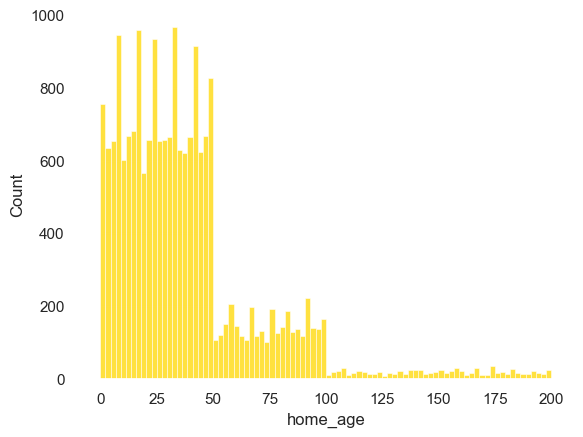

In [92]:
sns.histplot(energy_supplier['home_age'], color='#FFD700')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent
plt.title('Home Age Histogram', fontweight='bold')
plt.xlabel('Home Age')

Here we can also see three distinct levels at home's age, from 0 to 50 years old, 50 to 100 and 100 years and older. We turn this variable categorical. 

In [ ]:
#we define a function to categorize home's age 
def home_age_category(age):
    if age <= 50:
        return '0-50'
    elif age <= 100:
        return '50-100'
    else:
        return '100+'

#we apply the function 
energy_supplier['home_age'] = energy_supplier['home_age'].apply(home_age_category)

#and we turn the variable categorical 
energy_supplier['home_age'] = pd.Categorical(energy_supplier['home_age'])

## 4.3 Correlation Deep Dive

### 4.3.1 Relationship Length and Age

In [41]:
#we check if the correlation is significant
corr, p_value = pearsonr(energy_supplier['age'], energy_supplier['relation_length'])
#p-value < 0.05, therefore, significant positive correlation between both variables 

<span style="color:red">is it okay to use pearson here? Should I check for normality?</span>

Text(0, 0.5, 'Relationship Length')

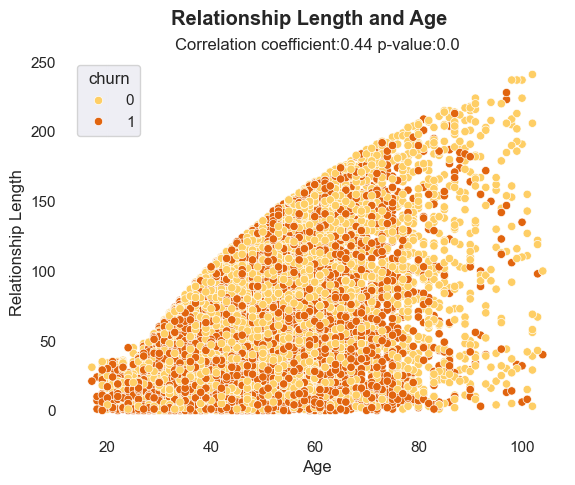

In [51]:
sns.scatterplot(energy_supplier, x='age', y='relation_length',  palette='YlOrBr', hue= 'churn')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent
plt.suptitle('Relationship Length and Age', fontweight='bold')
plt.title('Correlation coefficient:' + '{:.2f}'.format(corr) + ' p-value:' + str(p_value))
plt.xlabel('Age')
plt.ylabel('Relationship Length')

### 4.3.2 Electricity and Gas consumption

<Axes: >

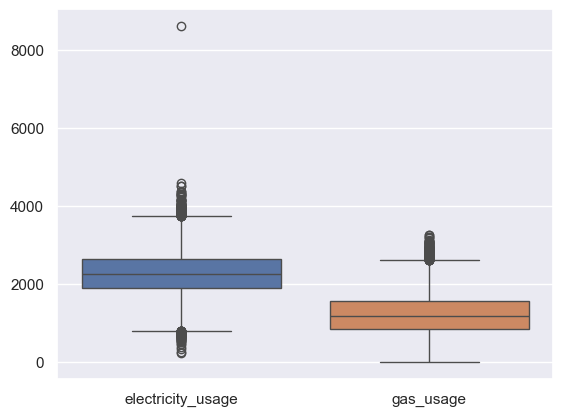

In [55]:
sns.boxplot(energy_supplier[['electricity_usage', 'gas_usage']])

In [57]:
pearsonr(energy_supplier['electricity_usage'], energy_supplier['gas_usage'])

PearsonRResult(statistic=0.2169881968290152, pvalue=9.599769406828578e-212)

<Axes: xlabel='electricity_usage', ylabel='gas_usage'>

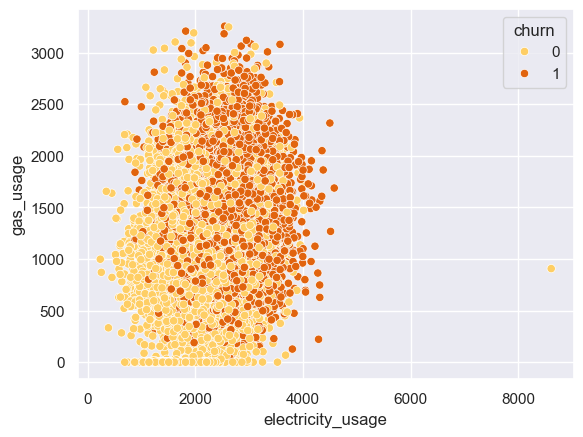

In [58]:
sns.scatterplot(energy_supplier, x='electricity_usage', y='gas_usage',  palette='YlOrBr', hue= 'churn')

<span style="color:red">Could this be due to an outlier? I just don't see the correlation here</span>

### 4.3.3 Statistics on Churn

#### 4.3.3.1 Electricity and Gas consumption

In [59]:
churned = energy_supplier[energy_supplier['churn']==1][['electricity_usage','gas_usage']]
not_churned = energy_supplier[energy_supplier['churn']==0][['electricity_usage','gas_usage']]

In [62]:
print(shapiro(churned))
shapiro((not_churned))

ShapiroResult(statistic=0.9888056189944433, pvalue=4.0205663840390565e-36)


/var/folders/y5/yrmbbwsx3sg3l8fv0bd8kxm80000gn/T/ipykernel_16834/907816349.py:1: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19604.
  print(shapiro(churned))
/var/folders/y5/yrmbbwsx3sg3l8fv0bd8kxm80000gn/T/ipykernel_16834/907816349.py:2: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20396.
  shapiro((not_churned))


ShapiroResult(statistic=0.9918564726782882, pvalue=4.6148602786103704e-32)

p-values lower than .05. We reject Ho, therefore, there is significant difference from a normal distribution

<span style="color:red">What is exactly following a normal distribution? I am not sure I understand</span>

In [63]:
mannwhitneyu(churned, not_churned)

MannwhitneyuResult(statistic=array([66639316.5, 63995583. ]), pvalue=array([0.00000000e+000, 2.26978457e-258]))

p-value < .05. We reject Ho, therefore, average electricity and gas usage on those who churned and styaed are different

<span style="color:red">Is this then giving me two different p-values?</span>

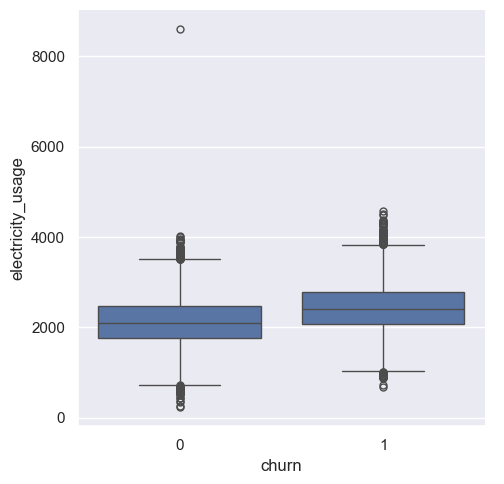

In [68]:
sns.catplot(data=energy_supplier, x="churn", y="electricity_usage", kind="box")

<Axes: xlabel='electricity_usage', ylabel='Count'>

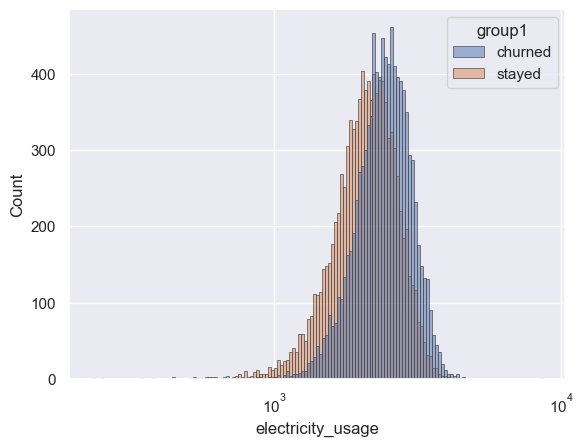

In [65]:
# Graph
energy_supplier['group1'] = energy_supplier['churn'].apply(lambda x: 'churned' if x in [1] else 'stayed')
sns.histplot(
    energy_supplier.loc[energy_supplier['electricity_usage']>0,:],
    x="electricity_usage", hue="group1",
    multiple="layer",
  #  palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,)

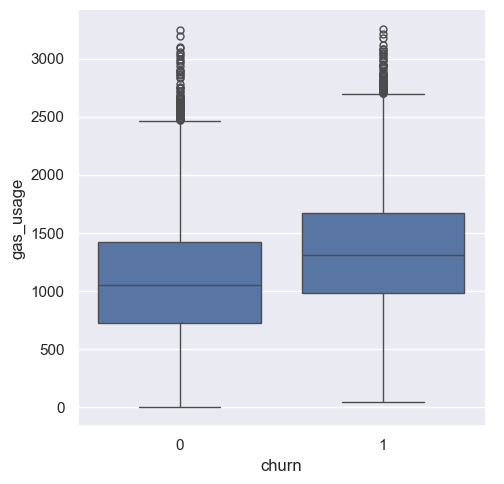

In [69]:
sns.catplot(data=energy_supplier, x="churn", y="gas_usage", kind="box")

<Axes: xlabel='gas_usage', ylabel='Count'>

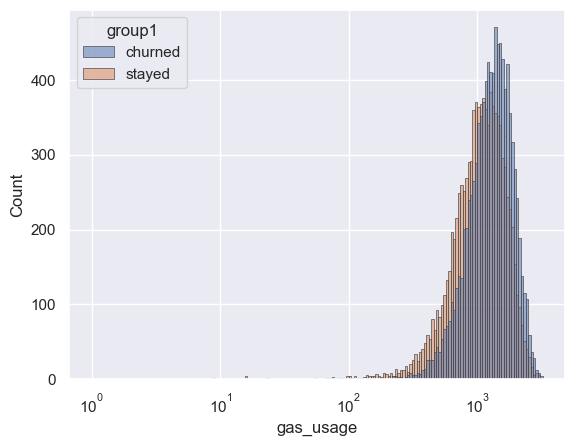

In [66]:
# Graph
energy_supplier['group1'] = energy_supplier['churn'].apply(lambda x: 'churned' if x in [1] else 'stayed')
sns.histplot(
    energy_supplier.loc[energy_supplier['gas_usage']>0,:],
    x="gas_usage", hue="group1",
    multiple="layer",
  #  palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,)

#### 4.3.3.2 Income, Relationship length and Contract Length 

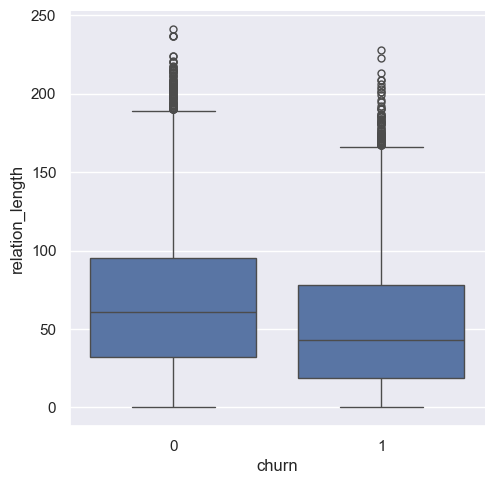

In [70]:
sns.catplot(data=energy_supplier, x="churn", y="relation_length", kind="box")

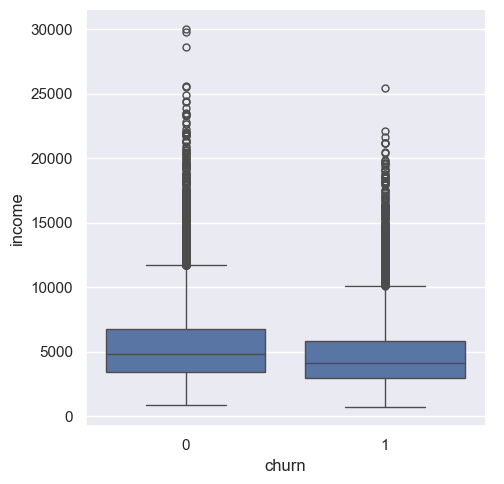

In [71]:
sns.catplot(data=energy_supplier, x="churn", y="income", kind="box")

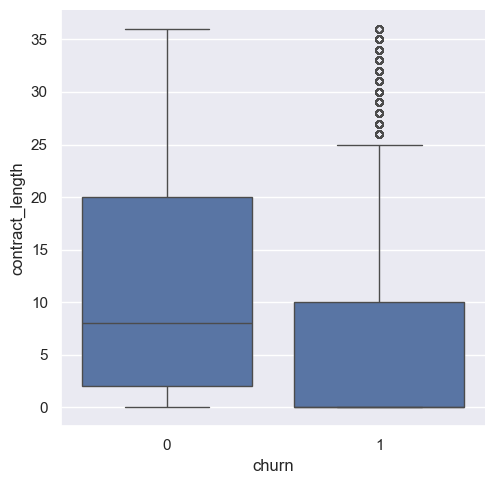

In [82]:
sns.catplot(data=energy_supplier, x="churn", y="contract_length", kind="box")

<Axes: xlabel='contract_length', ylabel='Count'>

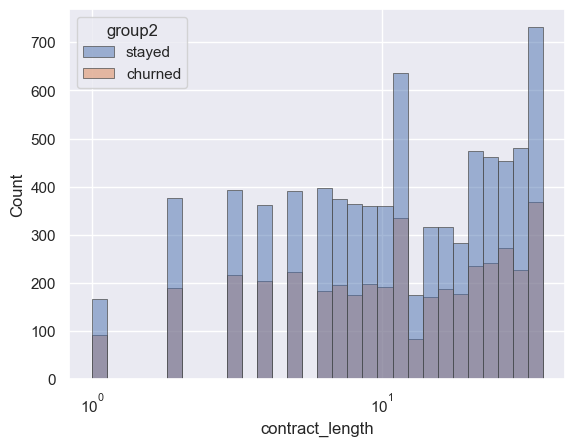

In [81]:
# Graph
energy_supplier['group2'] = energy_supplier['churn'].apply(lambda x: 'churned' if x in [1] else 'stayed')
sns.histplot(
    energy_supplier.loc[energy_supplier['contract_length']>0,:],
    x="contract_length", hue="group2",
    multiple="layer",
  #  palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,)

### Home Label and Home Age

/var/folders/y5/yrmbbwsx3sg3l8fv0bd8kxm80000gn/T/ipykernel_11987/1623687671.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='home_label', y='home_age', data=energy_supplier,  palette='YlOrBr')


Text(0, 0.5, 'Home Age')

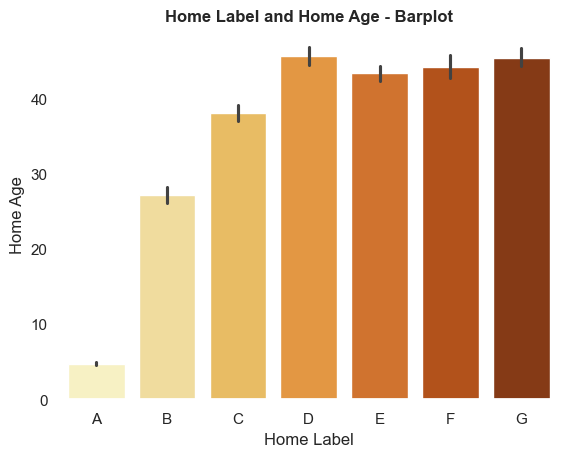

In [101]:
sns.barplot(x='home_label', y='home_age', data=energy_supplier,  palette='YlOrBr')
sns.set(rc={'figure.facecolor':'none'}) #set figure background to be transparent
plt.gca().set_facecolor('none')#set boxplot background to be transparent
plt.title('Home Label and Home Age - Barplot', fontweight='bold')
plt.xlabel('Home Label')
plt.ylabel('Home Age')

# 5. Classification Models

### 5.1 Logistic Regression

In [120]:
#we define the independent and dependent variables
X = energy_supplier[['gender', 'age', 'income', 'relation_length']]
y = energy_supplier['churn']

In [121]:
#we split the data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25, random_state=1234)

In [122]:
'''we create an instance of the logistic regression model.
An instance has all the methods and attributes associated with the logistic regression class, like fit, predict or coef'''
clf = LogisticRegression()

In [123]:
#here we train de model with the train dataset.
#when you run clf.fit(X_train, y_train), the trained logistic regression model is stored within the clf object.
clf.fit(X_train, y_train)

LogisticRegression()

In [124]:
#Now we do predictions with the train model in the test dataset
y_pred = clf.predict(X_test)

In [125]:
# Now we calculate the accuracy of the logistic regression model. It internally makes predictions using the x_test dataset and compares the
#prediction with the actual labels in y_test (comparing y_pred with y_test)
score = clf.score(X_test, y_test)
print("Accuracy: ", score)

Accuracy:  0.5878


In [126]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.57      0.59      2549
           1       0.58      0.61      0.59      2451

    accuracy                           0.59      5000
   macro avg       0.59      0.59      0.59      5000
weighted avg       0.59      0.59      0.59      5000



### 5.2 KNN (Introduccion_a_algoritmos_de_clasificacion - En modulo 3 Apredizaje supervisado clasificado)

### 5.3 SVM - Support Vector Machine

### 5.4 Decision Tree Model

In [116]:
X = energy_supplier.drop(columns=['churn', 'log_income', 'customer_id','group1','group2', 'start_channel'])
y = energy_supplier['churn']

In [ ]:
#we split the data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

In [118]:
plt.figure(figsize = (10,8))
DTC = DecisionTreeClassifier()
DTC.fit(X_train, y_train)
y_pred = DTC.predict(X_test)
plot_tree(DTC, filled=True)
plt.show()

ValueError: could not convert string to float: 'C'

<Figure size 1000x800 with 0 Axes>

In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2530
           1       0.52      0.53      0.53      2470

    accuracy                           0.53      5000
   macro avg       0.53      0.53      0.53      5000
weighted avg       0.53      0.53      0.53      5000



### 5.5 Random Forrest

In [ ]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)
y_preds = RFC.predict(X_test)
print(classification_report(y_test, y_preds))